In [138]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn import base
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import utils as u

In [139]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [140]:
# account for inflation?
# add median price per post code l3m?

In [141]:
sample_size = 2
random_seed = 42
test_size = 0.3
cv = 3

In [142]:
queries = u.get_queries('queries')

In [143]:
bq_client = bigquery.Client()

In [144]:
data = u.get_data(queries, 'training_data.sql', bq_client)

In [145]:
data.head()

,ad_id,apt_id,time_s,property_type_apartment,new_building,construction_year,ownership_full,floor,num_bedrooms,primary_size,address,price_per_sq_m
0,116762762,Enhet,3810.0,0,1,2019.0,1,NaN,4.0,141.0,"Idrettsvegen 16,...",46028.0
1,120529958,Bolig 4,6915.0,0,1,2019.0,1,NaN,4.0,143.0,"Gjeriveien 16, 2...",42035.0
2,131896301,14,6989.0,0,1,2019.0,1,NaN,4.0,144.0,"Plutosvingen, 21...",31680.0
3,135078656,B1.3.,4336.0,0,1,2019.0,1,NaN,3.0,102.0,"Svalevegen 2-16,...",37255.0
4,135078656,B1.5.,4336.0,0,1,2019.0,1,NaN,3.0,102.0,"Svalevegen 2-16,...",37255.0


In [146]:
data.shape

(6288, 12)

In [147]:
data = data[data.address.notnull()].copy()

In [148]:
data_sample = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed)
                                          if len(obj) > sample_size
                                          else obj.sample(len(obj)))

In [149]:
data = data.set_index(['ad_id', 'apt_id'], drop=True)

In [150]:
data.shape

(6288, 10)

In [151]:
class PostCodeExtractor(base.TransformerMixin, base.BaseEstimator):
    '''Extract the post code from the address column
    and drop the address column'''
    
    def __inint__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_c = X.copy()
        X_c['post_code'] = X_c['address'].str.extract(r'.*(\d{4}).*', expand=False)
        return X_c


class PostCodeEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the post code data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        post_codes = u.get_data(queries, 'post_code_area_name.sql', bq_client).set_index('post_code', drop=True)
        X = X.merge(post_codes, how='left', left_on='post_code', right_index=True)
        return X


class GmapsPlaceEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the gmaps data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        gmaps = u.get_data(queries, 'gmaps_lodging_dining_places.sql', bq_client).set_index('post_code', drop=True)
        X = X.merge(gmaps, how='left', left_on='post_code', right_index=True)
        return X


class NhsDataEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the nhs data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nhs = u.get_data(queries, 'uni_graduates_by_area_name.sql', bq_client).set_index('area_name', drop=True)
        X = X.merge(nhs, how='left', left_on='area_name', right_index=True)
        return X


class HistoricDataEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the mean historic prices per
    post cide and merge them with the
    training data'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        historic = u.get_data(queries, 'aggregate_price_last_n_months.sql', bq_client)
        historic_pivot = pd.pivot_table(data=historic,
                                        index='post_code',
                                        columns='property_type',
                                        values='price_per_sq_m',
                                        aggfunc='median')
        X = X.merge(historic_pivot, how='left', left_on='post_code', right_index=True)
        return X


class AuxiliaryColumnRemover(base.TransformerMixin, base.BaseEstimator):
    '''Remove the helper columns.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop(['post_code', 'area_name', 'settlement_name', 'address'], axis=1, inplace=True)
        return X


class CustomImputer(base.TransformerMixin, base.BaseEstimator):
    '''Impute various columns.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        X['floor'].fillna(1, inplace=True)
        X['time_s'].fillna(60 * 60 * 4, inplace=True)
        X['num_bedrooms'].fillna(0, inplace=True)
        X['num_lodging_places'].fillna(0, inplace=True)
        X['num_dining_places'].fillna(0, inplace=True)
        X['apartment'].fillna(X.apartment.median(), inplace=True)
        X['house'].fillna(X.house.median(), inplace=True)
        X['uni_graduates'].fillna(X.uni_graduates.mean(), inplace=True)
        # X.fillna(0, inplace=True)
        return X

In [152]:
data_enrichment = [('extract_post_code', PostCodeExtractor()),
                   ('add_area_name', PostCodeEnricher()),
                   ('add_gmaps_data', GmapsPlaceEnricher()),
                   ('add_nhs_data', NhsDataEnricher()),
                   ('add_historic_data', HistoricDataEnricher()),
                   ('remove_helper_columns', AuxiliaryColumnRemover()),
                   ('impute_features', CustomImputer())]

model_steps = [('scale', preprocessing.MinMaxScaler()),
               ('normalize', preprocessing.Normalizer()),
               ('model', ensemble.AdaBoostRegressor())]

In [153]:
enrichment_pipeline = pipeline.Pipeline(data_enrichment)

In [154]:
model_pipeline = pipeline.Pipeline(model_steps)

In [155]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

floor                      943
time_s                     147
num_bedrooms               136
price_per_sq_m               0
address                      0
primary_size                 0
ownership_full               0
construction_year            0
new_building                 0
property_type_apartment      0
dtype: int64

In [156]:
X = data.drop('price_per_sq_m', axis=1)
y = data.price_per_sq_m

In [157]:
X = enrichment_pipeline.fit_transform(X)

In [175]:
X.head()

time_s  property_type_apartment  new_building  \
ad_id     apt_id                                                   
116762762 Enhet    3810.0                    0                 1   
120529958 Bolig 4  6915.0                    0                 1   
131896301 14       6989.0                    0                 1   
135078656 B1.3.    4336.0                    0                 1   
          B1.5.    4336.0                    0                 1   

                   construction_year  ownership_full  floor  num_bedrooms  \
ad_id     apt_id                                                            
116762762 Enhet               2019.0               1    1.0           4.0   
120529958 Bolig 4             2019.0               1    1.0           4.0   
131896301 14                  2019.0               1    1.0           4.0   
135078656 B1.3.               2019.0               1    1.0           3.0   
          B1.5.               2019.0               1    1.0           3.0   

                   primary_size  num_lodging_places  num_dining_places  \
ad_id     apt_id                                                         
116762762 Enhet           141.0                 0.0                1.0   
120529958 Bolig 4         143.0                 0.0                1.0   
131896301 14              144.0                 0.0                0.0   
135078656 B1.3.           102.0                 0.0                0.0   
          B1.5.           102.0                 0.0                0.0   

                   uni_graduates  apartment    house  
ad_id     apt_id                                      
116762762 Enhet             0.44    61892.5  41353.5  
120529958 Bolig 4           0.47    55863.0  41743.0  
131896301 14                0.34    37854.0  41818.0  
135078656 B1.3.             0.34    38610.0  37255.0  
          B1.5.             0.34    38610.0  37255.0

In [159]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [160]:
X_train.shape

(4401, 13)

In [161]:
model_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('model',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=None))],
         verbose=False)

In [162]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data


def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = model_selection.cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val


def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [163]:
learning_curve_res = get_learning_curves(model_pipeline, X_train, y_train, score='neg_median_absolute_error', cv=cv)

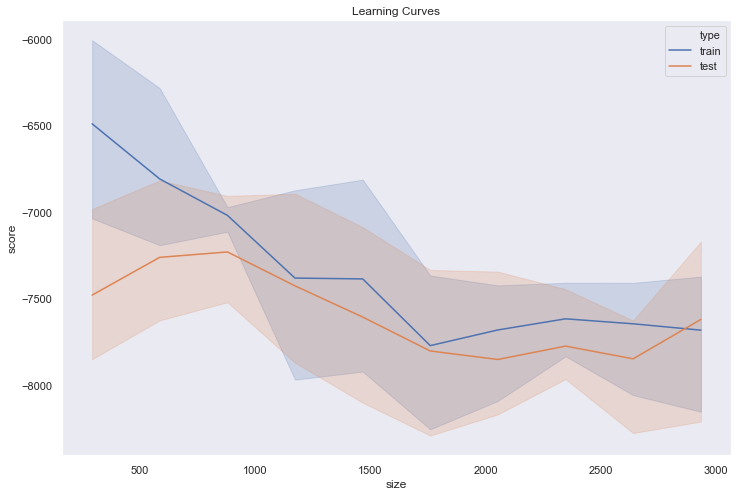

In [164]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

In [165]:
cv_res = get_cv_res(model_pipeline,
                    X_train,
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [166]:
print_cv_res(cv_res)

Mean fit_time, 0.19
Mean score_time, 0.03
Mean test_neg_median_absolute_error, -7858.19
Mean test_r2, 0.74
Mean test_explained_variance, 0.77
Mean test_max_error, -81335.05


In [167]:
pred = model_pipeline.predict(X_test)

In [168]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [169]:
y_pred.head()

ad_id      apt_id
106216592  4          81373.528594
135345266  NaN       125603.522258
150399075  NaN        65612.410689
151035018  NaN        57045.189533
122506626  402        60718.822547
Name: predicted, dtype: float64

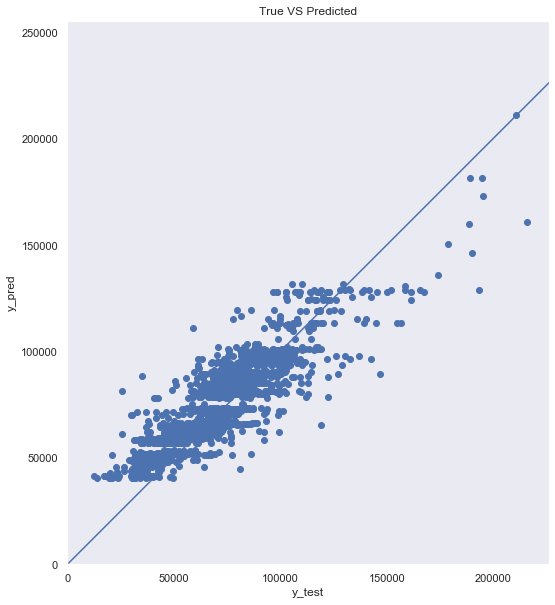

In [170]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

In [171]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']

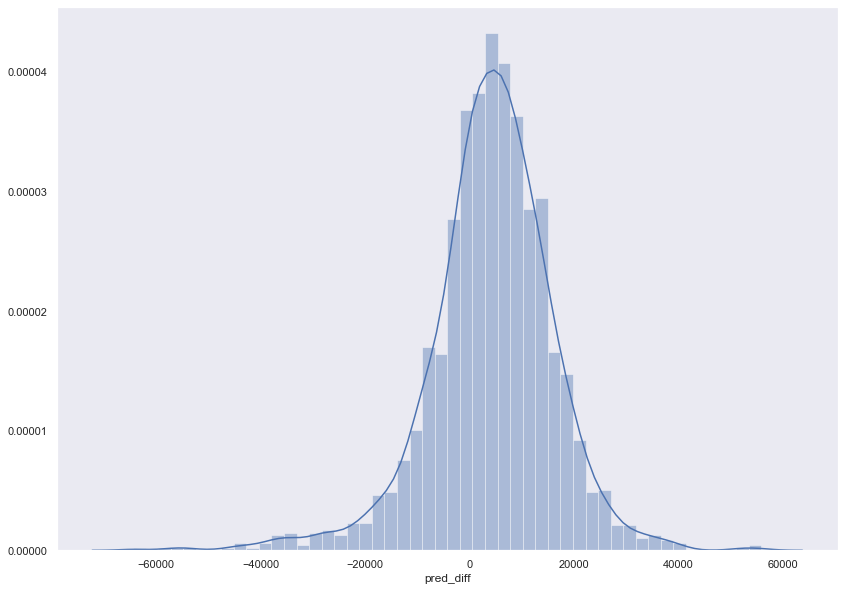

In [172]:
sns.distplot(to_plot.pred_diff)

In [173]:
feature_importances = pd.Series(model_pipeline.named_steps['model'].feature_importances_,
                                index=enrichment_pipeline.named_steps['impute_features'].columns).sort_values(ascending=True)

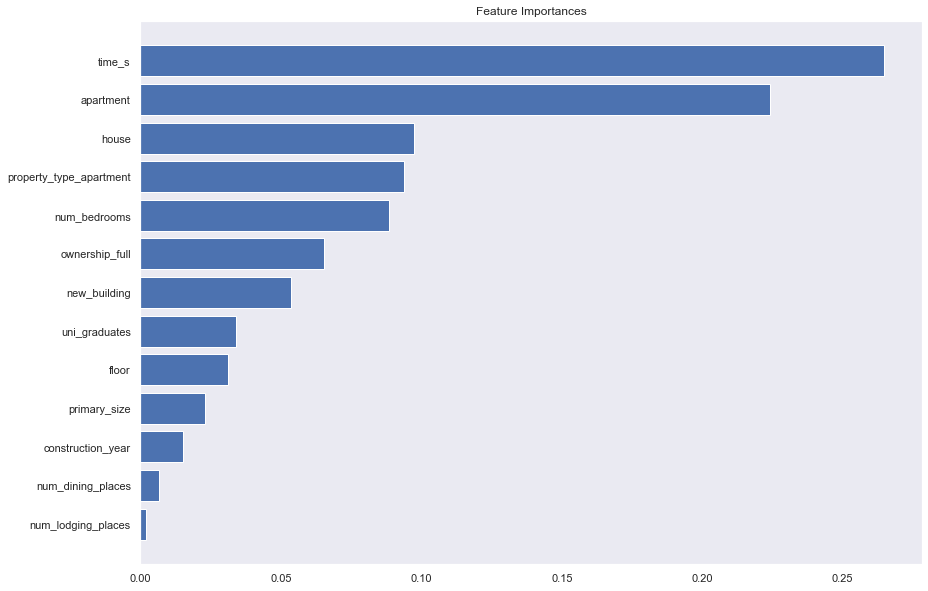

In [174]:
to_plot = feature_importances
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()